In [1]:
import sys
import os

In [2]:
path = os.path.abspath(os.pardir)

if path not in sys.path:
    sys.path.append(path)

In [5]:
import utils.transforms as transforms
from metrics.metrics_utils import MetricsManager

import segmentation.tiramisu.tiramisu as tiramisu
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os

%matplotlib inline

In [4]:
#torch.backends.cudnn.enabled = False


In [5]:
model = tiramisu.FCDenseNet103(n_classes=2)

if torch.cuda.is_available():
    model = torch.nn.DataParallel(model).cuda()

In [6]:
criterion = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
    criterion = criterion.cuda()

In [7]:
optimizer_params = {"momentum": 0.9,
        "lr": 0.001,
        "weight_decay": 0.0001
    }

optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), **optimizer_params)

In [8]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.995)

In [9]:
train_transform = transforms.Compose(
    [
        transforms.ShiftScaleRotate(rotate_limit=90, shift_limit=[0, 0.2], scale_limit=[0, 0.11],
                                    interpolation=1, p=0.5),
        transforms.HorizontalFlip(),
        transforms.VerticalFlip(),
        transforms.ToTensor(normalize={
                        "mean": [0.322, 0.339, 0.301],
                        "std": [0.133, 0.133, 0.114]
                    })
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(normalize={
                        "mean": [0.322, 0.339, 0.301],
                        "std": [0.133, 0.133, 0.114]
                    }),
    ]
)

In [10]:
class ImageMaskCSVDataset(Dataset):
    def __init__(self, labels, 
                 image_column, mask_column, 
                 images_folder, masks_folder, 
                 transform=None):
        
        self.transform = transform
        self.labels = labels

        self.image_column = image_column
        self.mask_column = mask_column

        self.images_folder = images_folder
        self.masks_folder = masks_folder

    def process_new_item(self, index):
        row = self.labels.iloc[index]

        file_path = row[self.image_column]
        image = cv2.imread(os.path.join(self.images_folder, file_path))[:, :, ::-1]

        mask_path = row[self.mask_column]
        mask = cv2.imread(os.path.join(self.masks_folder, mask_path))[:, :, 0]

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        sample = {'image': image,
                  'mask': mask
                 }

        return sample

    def __getitem__(self, index):
        result = self.process_new_item(index)
        return result

    def __len__(self):
        return len(self.labels)

In [14]:
train_dataset = ImageMaskCSVDataset(pd.read_csv('../../data/segmentation/train.csv'), 
                                    'img_path', 'mask_path', 
                                    '../../data/segmentation/patches_224x224/',
                                    '../../data/segmentation/patches_224x224/',
                                    train_transform)
valid_dataset = ImageMaskCSVDataset(pd.read_csv('../../data/segmentation/valid.csv'), 
                                    'img_path', 'mask_path', 
                                    '../../data/segmentation/patches_224x224/',
                                    '../../data/segmentation/patches_224x224/',
                                    test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=20,
                              shuffle=True, num_workers=0,
                              pin_memory=torch.cuda.is_available())
valid_dataloader = DataLoader(valid_dataset, batch_size=20,
                             shuffle=False, num_workers=0,
                             pin_memory=torch.cuda.is_available())

In [12]:
def run_train_val_loader(metrics_manager, epoch, loader, mode, model,
                         criterion, optimizer):
    """Runs one epoch of the training loop.
    :param metrics_manager: MetricsManager instance
    :param epoch: index of the epoch
    :param loader: data loader
    :param mode: 'train' or 'valid'
    :param model: model for training \ validation
    :param criterion: loss function to minimize
    :param optimizer: optimisation function
    """
    if mode == 'train':
        model.train()
    else:
        model.eval()

    for i, batch in tqdm(enumerate(loader), total=len(loader)):
        if torch.cuda.is_available():
            input_var = torch.autograd.Variable(batch['image'].cuda(async=True), requires_grad=False)
        else:
            input_var = torch.autograd.Variable(batch['image'], requires_grad=False)

        if torch.cuda.is_available():
            target_var = torch.autograd.Variable(batch['mask'].type(torch.int64).cuda(async=True), requires_grad=False)
        else:
            target_var = torch.autograd.Variable(batch['mask'].type(torch.int64), requires_grad=False)
        target_var = target_var.squeeze()

        with torch.set_grad_enabled(mode == 'train'):
            output = model.forward(input_var)
            loss = criterion(output, target_var)
            loss_val = float(loss.data.cpu().numpy())

            if mode == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                metrics_manager.update_epoch_train_metrics(
                    loss_val, output.data, target_var.data
                )
            else:
                metrics_manager.update_epoch_valid_metrics(
                    loss_val, output.data, target_var.data
                )

    train_loss, valid_loss = metrics_manager.get_cur_loss()
    if mode == 'train':
        epoch_metrics_str = "loss\t{:.3f}".format(train_loss)
    else:      
        epoch_metrics_str = "loss\t{:.3f}".format(valid_loss)
    print("{epoch} * Epoch ({mode}): ".format(epoch=epoch, mode=mode), epoch_metrics_str)

    return metrics_manager.get_cur_loss()

In [16]:

num_epoch = 5

fake_hparams = {    "metrics": [
        {
            "name": "SegmentationConfusionMeter",
            "params": None
        },
        {
            "name": "MeanIntersectionOverIUnionMeter",
            "params": None
        }
    ]
}

metrics_manager = MetricsManager(hparams=fake_hparams, k=2)

for epoch in range(num_epoch):
    metrics_manager.add_epoch()
    
    train_loss = run_train_val_loader(metrics_manager, epoch, train_dataloader, 'train',
                                      model, criterion, optimizer)
    valid_loss = run_train_val_loader(metrics_manager, epoch, valid_dataloader, 'valid',
                                      model, criterion, optimizer)

    scheduler.step()

0 * Epoch (train):  loss	0.301


0 * Epoch (valid):  loss	0.200


1 * Epoch (train):  loss	0.228


1 * Epoch (valid):  loss	0.201


KeyboardInterrupt: 

In [28]:
white / (white + black)

0.17187206424061252

In [27]:
white = 0
black = 0
for idx, mask_path in enumerate(df_train['mask'], 2):
    mask = cv2.imread(mask_path)[..., ::-1]
    white += mask[mask == 255].size
    black += mask[mask == 0].size
    
white / black

0.2075428889897393

In [86]:
img = cv2.imread(df_test['img'][0])[..., ::-1] / 255.
f_m = img[..., 0].mean()
s_m = img[..., 1].mean()
t_m = img[..., 2].mean()

f_se = np.mean((img[..., 0] - f_m) ** 2)
s_se = np.mean((img[..., 1] - s_m) ** 2)
t_se = np.mean((img[..., 2] - t_m) ** 2)

first = f_m
second = s_m
third = t_m

first_mse = f_se
second_mse = s_se
third_mse = t_se

for idx, img_path in enumerate(df_train['img'], 2):
    
    img = cv2.imread(img_path)[..., ::-1] / 255.
    f_m = img[..., 0].mean()
    s_m = img[..., 1].mean()
    t_m = img[..., 2].mean()

    f_se = np.mean((img[..., 0] - f_m) ** 2)
    s_se = np.mean((img[..., 1] - s_m) ** 2)
    t_se = np.mean((img[..., 2] - t_m) ** 2)
    
    first = (idx-1) * first / idx + f_m / idx
    second = (idx-1) * second / idx + s_m / idx
    third = (idx-1) * third / idx + t_m / idx
    
    first_mse = (idx-1) * first_mse / idx + f_se / idx
    second_mse = (idx-1) * second_mse / idx + s_se / idx
    third_mse = (idx-1) * third_mse / idx + t_se / idx

In [90]:
np.round(first, 3), np.round(second, 3), np.round(third, 3)

(0.322, 0.339, 0.301)

In [89]:
np.round(first_mse ** 0.5, 3), np.round(second_mse ** 0.5, 3), np.round(third_mse ** 0.5, 3)

(0.133, 0.133, 0.114)

In [35]:
image = cv2.imread('/home/ubuntu/data/segmentation/train/A14OK5A65AR5AOST/A14OK5A65AR5AOST.png')[..., ::-1]
mask = cv2.imread('/home/ubuntu/data/segmentation/train/A14OK5A65AR5AOST/A14OK5A65AR5AOST_mask.png')#[..., 0]



In [21]:
plt.rcParams['figure.figsize'] = 20, 20

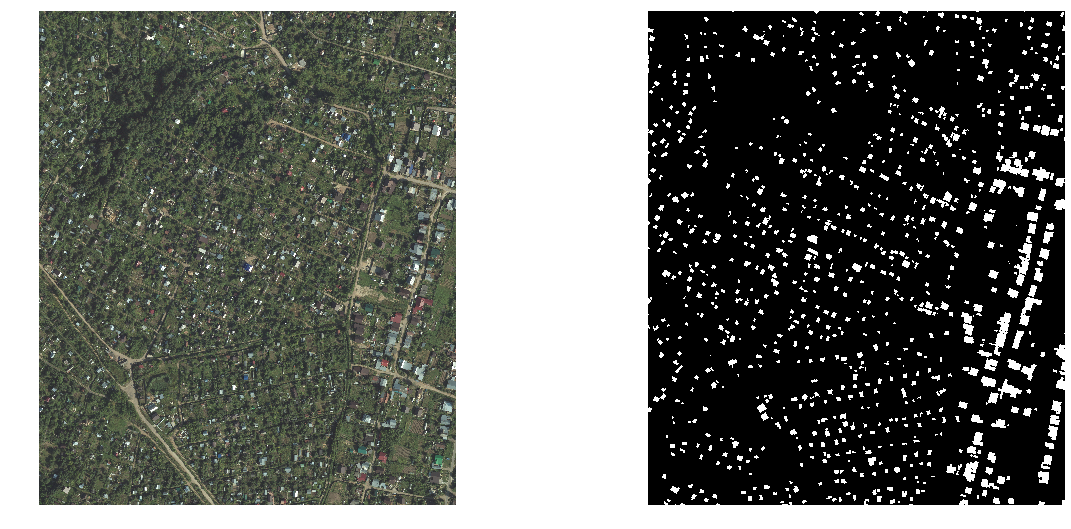

In [34]:
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(image)
plt.subplot(2,2,2)
plt.axis('off')
plt.imshow(mask, cmap=plt.cm.gray)

In [19]:
train_dataset[0]['image'].shape

torch.Size([3, 250, 250])

In [23]:
train = []
for root, dirs, files in os.walk('/home/ubuntu/data/segmentation/train/'):
    row = {}
    for file in files:
        if file.endswith('_mask.png'):
            row['mask'] = os.path.join(root, file)
        elif file.endswith('.png'):
            row['img'] = os.path.join(root, file)
    if row:
        train.append(row)

In [24]:
df_train = pd.DataFrame(train)
df_train

img  \
0  /home/ubuntu/data/segmentation/train/E1QZENNLN...   
1  /home/ubuntu/data/segmentation/train/8B7JP60TY...   
2  /home/ubuntu/data/segmentation/train/SQ77SFLTI...   
3  /home/ubuntu/data/segmentation/train/A14OK5A65...   
4  /home/ubuntu/data/segmentation/train/FOCNEZJJ9...   
5  /home/ubuntu/data/segmentation/train/T4ZUFU918...   
6  /home/ubuntu/data/segmentation/train/E60M2WMEL...   
7  /home/ubuntu/data/segmentation/train/YTS6DUZYS...   
8  /home/ubuntu/data/segmentation/train/AZ74029PB...   
9  /home/ubuntu/data/segmentation/train/LJJ5AQ6GY...   

                                                mask  
0  /home/ubuntu/data/segmentation/train/E1QZENNLN...  
1  /home/ubuntu/data/segmentation/train/8B7JP60TY...  
2  /home/ubuntu/data/segmentation/train/SQ77SFLTI...  
3  /home/ubuntu/data/segmentation/train/A14OK5A65...  
4  /home/ubuntu/data/segmentation/train/FOCNEZJJ9...  
5  /home/ubuntu/data/segmentation/train/T4ZUFU918...  
6  /home/ubuntu/data/segmentation/train/E60M2WMEL...  
7  /home/ubuntu/data/segmentation/train/YTS6DUZYS...  
8  /home/ubuntu/data/segmentation/train/AZ74029PB...  
9  /home/ubuntu/data/segmentation/train/LJJ5AQ6GY...

In [6]:
test = []
for root, dirs, files in os.walk('/home/ubuntu/data/segmentation/test/'):
    row = {}
    for file in files:
        if file.endswith('_mask.png'):
            row['mask'] = os.path.join(root, file)
        elif file.endswith('.png'):
            row['img'] = os.path.join(root, file)
    if row:
        test.append(row)

In [9]:
df_test = pd.DataFrame(test)
df_test[1:].to_csv('/home/ubuntu/data/segmentation/test/test.csv')

In [12]:
df_test[1:]['img'].values

array(['/home/ubuntu/data/segmentation/test/ZRYNEEUSVQ213QTY/ZRYNEEUSVQ213QTY.png',
       '/home/ubuntu/data/segmentation/test/P2MLF2MV9K9XIYUI/P2MLF2MV9K9XIYUI.png',
       '/home/ubuntu/data/segmentation/test/KHSF2T5PXCKI0978/KHSF2T5PXCKI0978.png'],
      dtype=object)

In [58]:
a = np.array([0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0])

run_lengths, positions, elements = rle(a)

s = ''
#for i, e in enumerate(elements):
#    if e == 0:
#        little_s = str(positions[i]) + ' ' + str(run_lengths[i]) + ' '
#        s += little_s
        
for elem in zip(elements, positions, run_lengths):
    print(elem)
    if elem[0] == 0:
        little_s = str(elem[1] + 1) + ' ' + str(elem[2]) + ' '
        s += little_s
        
s = s.strip()
s

(0, 0, 2)
(1, 2, 2)
(0, 4, 2)
(1, 6, 3)
(0, 9, 4)


'1 2 5 2 10 4'

In [53]:
run_len_enc = pd.read_csv('/home/ubuntu/data/segmentation/train/A14OK5A65AR5AOST/A14OK5A65AR5AOST.csv', header=None)

#run_len_enc[1]

In [39]:
true_s = ''
for line in run_len_enc[1]:
    true_s += line + ' '
    
true_s = true_s.strip()   

In [46]:
mask_flat = mask.flatten()

In [60]:
run_lengths, positions, elements = rle(mask_flat)

s = ''
for elem in zip(elements, positions, run_lengths):
    if elem[0] == 255:
        little_s = str(elem[1] + 1) + ' ' + str(elem[2]) + ' '
        s += little_s
        
s = s.strip()
s

'11660 44 12387 48 17034 98 17350 82 18183 44 18910 48 21821 44 22178 73 23557 97 23873 82 24705 44 25432 48 27387 66 28345 42 28700 76 30079 98 30395 82 31228 44 31955 48 33911 64 34869 40 35223 77 36602 97 36918 82 37751 44 38478 48 40435 62 41394 38 41745 79 43124 98 43441 82 44274 43 45001 48 46960 59 47918 36 48267 82 49247 2 49647 97 49966 80 50796 44 51523 48 53484 58 54442 34 54790 83 55770 4 56169 98 56493 75 57319 44 58046 48 60008 56 60967 31 61312 85 62292 7 62692 97 63019 72 63842 44 64569 48 66532 54 67491 30 67833 86 68815 9 69214 98 69546 68 70364 44 71091 49 73056 52 74015 28 74352 89 75337 12 75737 97 76073 63 76887 44 77614 48 79581 49 80539 26 80872 91 81860 14 82259 98 82599 60 83410 44 84137 48 86105 47 87064 23 87389 96 88382 18 88782 97 89126 56 89932 44 90659 49 92629 45 93588 22 93908 99 94905 20 95304 98 95652 53 96455 44 97182 48 99153 43 100112 20 100432 98 101427 23 101827 97 102179 48 102978 44 103705 48 105678 41 106637 17 106956 96 107950 25 108349 98 1

In [7]:
def rle(inarray):
    """ run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) """
    n = len(inarray)
    if n == 0: 
        return (None, None, None)
    else:
        y = np.array(inarray[1:] != inarray[:-1])     # pairwise unequal (string safe)
        i = np.append(np.where(y), n - 1)   # must include last element posi
        z = np.diff(np.append(-1, i))       # run lengths
        p = np.cumsum(np.append(0, z))[:-1] # positions
        return(z, p, inarray[i])

def create_mask_rle(mask):
    mask_flat = mask.flatten()
    
    run_lengths, positions, elements = rle(mask_flat)

    s = ''
    for elem in zip(elements, positions, run_lengths):
        if elem[0] == 255:
            little_s = str(elem[1] + 1) + ' ' + str(elem[2]) + ' '
            s += little_s

    return s.strip()

def create_submission(mask, 
                      filename='2YNGEOYOEH0YXBJV', 
                      path='/home/ubuntu/data/segmentation/test/2YNGEOYOEH0YXBJV/'):
    out_rle = create_mask_rle(mask)
    df = pd.DataFrame([{filename + '.png': out_rle}]).T
    df.to_csv(os.path.join(path, filename + '.csv'),header=False)
    

In [75]:
create_submission(mask)

In [78]:
pd.read_csv('/home/ubuntu/data/segmentation/test/2YNGEOYOEH0YXBJV/2YNGEOYOEH0YXBJV.csv', index_col=0, header=None)

1
0                                                                      
2YNGEOYOEH0YXBJV.png  11660 44 12387 48 17034 98 17350 82 18183 44 1...

In [72]:
pd.DataFrame([{'2YNGEOYOEH0YXBJV.png': s}]).T

0
2YNGEOYOEH0YXBJV.png  11660 44 12387 48 17034 98 17350 82 18183 44 1...

In [20]:
import pycocotools.cocoeval as coco
import base64

In [17]:
code = coco.maskUtils.encode(np.asfortranarray(mask))

In [26]:
base64.standard_b64decode(code['counts'])

b'\x9f\xc95Ka\x0b\x9e\x8e\xb6m\x926\x10\xb7\xb5KXtT\xd4N{E\xd9\xe7\x84 \'a\x0cwS\xf5v\x1d\x155\x03\x9e\xd1\xbdS\xd6~\x8f9\xf1\xe34\xf97_T\x14/a\x0c{Y4\x86\x1d\x186c\x9f\xd1\xcdT\xd6^\x8f9\xc1\xe65~\xe7X\xe7t\x8f\x89\x8d\xd6M\x1a\x8ff\xf4l\xcd\x841\xed`\xd2Xt6S\x9e\xd1\xbdW\xd6>\x8f9\xb1\xe75\x7fdX\xe6\xf4?\x98\xcd\xd6m\x11\xd7e4t\xdd\x9a\x10\xb7uwD"\xd0\xd7\x149c\x98\xf3]\x99\xd6\x1e\x8f8s\xce^=O9\xf34CU\xd1\xd7\x86'

In [27]:
code

{'size': [7736, 6523],
 'counts': b'n8k1S;2`ELno62bZI2`ELe1S1`h0VNR_Oe0XZ54QgJ2`EMd1P1dh0VNQ_Oe0b1T1n6POfHjNPk3X1QUL2`EMe1k0hh0YNm^Of0c1U1l6POcHmNX=7nWOd0j4mN1k0aj2b0b[M2`EMe1g0lh0[Nl^Oe0b1X1j6PObHnNX=9kWOb0P5jN1m0^R12U?`0^dN2aELd1d0Qi0]NcUOWOY8^1_2Z1h6PO`HPOX=j1P]OfM0Q1XR14Y?=]dN3aELd1?Wi0_N^UO[OY8Z1a2\\1f6oNaHQOU=j1T]OdM0S1TR15[?<]dN3aELe1:[i0bNXUO@Y8V1c2]1e6PO`HPOV=j1U]OcM1S1oQ19]?9_dN2`EJh19X7QNa8b0h^ODY8R1e2`1b6oNaHQOS=j1Z]O`M0V1kQ1;^?7`dN2`EDn1JaMTOc9E^8>i^OGY8n0g2b1`6oNaHPOR=k1]]O^M0X1fQ1=a?5`dN2`E^OU2K^MUOb9J\\8;h^OKY8j0h2d1_6nNbHROQ=h1lBiNTl0>c?3adNKgE@S2L^MTO_92Z86g^O0Y8f0k2e1]6kNeHUOn<f1nBkNok0a0e?0Z]NWN[3X1PJFm1N\\MTO^98W81h^O5X8a0n2h1Z6iNgHVOm<e1oBmNjk0c0h?NW]NZN^3i0]JLf1OW7Ce7Mg^O8Y8>n2j1Y6gNiHYOl<a1QCoNek0f0i?LV]N]N_3:jJ2`10U7Ja7Ig^O<Y8:P3l1W6dNlH\\Oi<_1SCQO`k0i0k?IT]N`Nb3KVK8Z12Q71^7Eg^O`0Y85S3m1W6cNlH]Oh<_1SCSO\\k0i0n?IP]NbNW6KTJ3o66\\7Ag^Oe0X81U3l1W6dNlH@f<\\1UCUOWk0l0Q`0Em\\NgNY6A\\J4j6>Z7\\Og^Oi0X8MZ1ZO^Gb2f`0dNlHAe<[1VCWOSk0n0R`0Ck\\NjN`:^OUMd0R85TFIY1_O^G]2Z4`MY6T

In [31]:
# Run-Length Encode and Decode

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# Time Test
#masks = pd.read_csv('../input/train_masks.csv')
#num_masks = masks.shape[0]
#print('Total masks to encode/decode =', num_masks)

#time_enc = 0.0 # seconds
#time_dec = 0.0 # seconds

#for r in masks.itertuples():
#     t0 = time.clock()
#     mask = rle_decode(r.rle_mask,(1280,1918))
#     time_dec += time.clock() - t0
#     t0 = time.clock()   
#     mask_rle = rle_encode(mask)
#     time_enc += time.clock() - t0
    #assert (mask_rle == r.rle_mask)

#print('Time full encoding = {:.4f} ms per mask'.format(1000*time_enc/num_masks))
#print('Time full decoding = {:.4f} ms per mask'.format(1000*time_dec/num_masks))

In [38]:
rle_encode(mask[..., 0])

'11660 44 12387 48 17034 98 17350 82 18183 44 18910 48 21821 44 22178 73 23557 97 23873 82 24705 44 25432 48 27387 66 28345 42 28700 76 30079 98 30395 82 31228 44 31955 48 33911 64 34869 40 35223 77 36602 97 36918 82 37751 44 38478 48 40435 62 41394 38 41745 79 43124 98 43441 82 44274 43 45001 48 46960 59 47918 36 48267 82 49247 2 49647 97 49966 80 50796 44 51523 48 53484 58 54442 34 54790 83 55770 4 56169 98 56493 75 57319 44 58046 48 60008 56 60967 31 61312 85 62292 7 62692 97 63019 72 63842 44 64569 48 66532 54 67491 30 67833 86 68815 9 69214 98 69546 68 70364 44 71091 49 73056 52 74015 28 74352 89 75337 12 75737 97 76073 63 76887 44 77614 48 79581 49 80539 26 80872 91 81860 14 82259 98 82599 60 83410 44 84137 48 86105 47 87064 23 87389 96 88382 18 88782 97 89126 56 89932 44 90659 49 92629 45 93588 22 93908 99 94905 20 95304 98 95652 53 96455 44 97182 48 99153 43 100112 20 100432 98 101427 23 101827 97 102179 48 102978 44 103705 48 105678 41 106637 17 106956 96 107950 25 108349 98 1

In [30]:
from skimage.morphology import label
import cv2
import os
import numpy as np
from tqdm import tqdm


def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in tqdm(np.unique(labels[labels>0]))]


# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.bool_)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = True
    return img.reshape(shape)  # Needed to align to RLE direction


def masks_as_image(in_mask_list, shape=(768, 768)):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros(shape, dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)


def read_masks(mask_rles, shape=(768, 768)):
    masks = np.zeros((shape[0], shape[1]))
    for idx, rle in enumerate(mask_rles):
        if isinstance(rle, str):
            masks[rle_decode(rle, shape)] = idx + 1
    return masks


def init_masks(root, df, shape=(768, 768)):
    try:
        os.mkdir(root)
    except FileExistsError:
        pass

    keys = np.unique(df.ImageId.values)
    for key in tqdm(keys):
        eps = df.query('ImageId==@key').EncodedPixels
        mask = masks_as_image(eps, shape)
        key = key.replace('.jpg', '.png')
        cv2.imwrite(os.path.join(root, key), np.squeeze(mask) * 255)

In [17]:
rle_encode(mask)

'287 59 701 61 781 57 8023 59 8437 61 8517 57 8646 92 9594 34 9942 55 15759 59 16173 61 16253 58 16382 90 17331 32 17679 53 18098 89 18775 57 19186 19 23495 59 23909 61 23989 58 24119 85 25068 30 25415 52 25835 89 26512 57 26920 22 27717 29 27751 49 27959 14 28133 41 31231 59 31645 61 31725 58 31855 81 32804 28 33152 49 33571 89 34248 57 34655 23 35452 32 35485 50 35696 12 35870 41 37175 43 38967 59 39381 61 39462 57 39591 77 40541 26 40595 1 40889 47 41308 89 41985 57 42390 25 43187 83 43434 9 43607 42 44909 46 46704 59 47117 62 47198 58 47327 73 48278 24 48330 3 48626 45 49045 89 49722 56 50127 25 50922 83 51171 7 51344 42 52644 47 54440 59 54853 62 54934 58 55064 68 56015 22 56064 6 56362 44 56781 89 57458 57 57863 25 58658 83 58908 6 59082 41 60378 50 62176 59 62590 61 62670 55 62800 64 63171 1 63752 19 63799 7 64099 41 64518 89 65195 56 65600 25 66393 83 66646 3 66819 41 68113 52 69912 59 70326 61 70406 49 70536 43 70581 15 70905 4 71488 18 71534 9 71836 39 72255 89 72932 56 73337

In [14]:
create_mask_rle(mask)

'11660 44 12387 48 17034 98 17350 82 18183 44 18910 48 21821 44 22178 73 23557 97 23873 82 24705 44 25432 48 27387 66 28345 42 28700 76 30079 98 30395 82 31228 44 31955 48 33911 64 34869 40 35223 77 36602 97 36918 82 37751 44 38478 48 40435 62 41394 38 41745 79 43124 98 43441 82 44274 43 45001 48 46960 59 47918 36 48267 82 49247 2 49647 97 49966 80 50796 44 51523 48 53484 58 54442 34 54790 83 55770 4 56169 98 56493 75 57319 44 58046 48 60008 56 60967 31 61312 85 62292 7 62692 97 63019 72 63842 44 64569 48 66532 54 67491 30 67833 86 68815 9 69214 98 69546 68 70364 44 71091 49 73056 52 74015 28 74352 89 75337 12 75737 97 76073 63 76887 44 77614 48 79581 49 80539 26 80872 91 81860 14 82259 98 82599 60 83410 44 84137 48 86105 47 87064 23 87389 96 88382 18 88782 97 89126 56 89932 44 90659 49 92629 45 93588 22 93908 99 94905 20 95304 98 95652 53 96455 44 97182 48 99153 43 100112 20 100432 98 101427 23 101827 97 102179 48 102978 44 103705 48 105678 41 106637 17 106956 96 107950 25 108349 98 1